In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('formatted_expenses.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,trans_id,account_id,date,type,amount,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,...,last_trans_11,last_trans_12,last_trans_13,last_trans_14,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20
0,201,1,1995-06-22,1,72.000,72.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202,1,1995-07-22,1,1908.000,1908.000,72.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,203,1,1995-08-21,1,2700.000,2700.000,1908.000,72.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,159,1,1995-08-31,1,5.256,5.256,2700.000,1908.000,72.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58,1,1995-09-05,1,882.720,882.720,5.256,2700.000,1908.000,72.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139368,307078,1047,1998-11-23,1,475.200,475.200,1562.040,5.256,1562.040,216.000,...,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256,1562.040,5.256
139369,307138,1047,1998-11-30,1,5.256,5.256,475.200,1562.040,5.256,1562.040,...,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256,1562.040
139370,307020,1047,1998-12-05,1,1562.040,1562.040,5.256,475.200,1562.040,5.256,...,1562.040,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256
139371,307030,1047,1998-12-08,1,576.000,576.000,1562.040,5.256,475.200,1562.040,...,5.256,1562.040,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000


In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['weekday'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [4]:
df['account_id'].value_counts()

96      479
866     476
655     467
396     456
1006    435
       ... 
672       5
758       4
315       4
182       3
727       2
Name: account_id, Length: 1000, dtype: int64

In [7]:
single_user_data = df[df['account_id']==96].fillna(0).drop(['date'],axis=1).reset_index()

split = int(len(single_user_data) * 0.8)
train = single_user_data[:split]
test = single_user_data[split:]

# scaler = MinMaxScaler(feature_range=(0, 1))
x_t = train.drop(['amount', 'trans_id'], axis=1)
y_t = pd.DataFrame(train['amount'])
x_s = test.drop(['amount', 'trans_id'], axis=1)
y_s = pd.DataFrame(test['amount'])

x_train = x_t # scaler.fit_transform(x_t)
y_train = y_t # scaler.fit_transform(y_t)

x_test = x_s # scaler.fit_transform(x_s)
y_test = y_s # scaler.fit_transform(y_s)

single_user_data

# x_train = train.drop(['amount', 'trans_id'], axis=1)
# y_train = train['amount']
# x_test = test.drop(['amount', 'trans_id'], axis=1)
# y_test = test['amount']

,index,trans_id,account_id,type,amount,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
0,13177,29727,96,1,4140.00,4140.00,0.00,0.00,0.00,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,5,20,3,1993
1,13178,29728,96,1,8892.00,8892.00,4140.00,0.00,0.00,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,0,19,4,1993
2,13179,29729,96,1,12636.00,12636.00,8892.00,4140.00,0.00,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,2,19,5,1993
3,13180,29730,96,1,22644.00,22644.00,12636.00,8892.00,4140.00,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,4,11,6,1993
4,13181,29731,96,1,6912.00,6912.00,22644.00,12636.00,8892.00,4140.000,...,0.000,0.00,0.00,0.000,0.000,0.000,4,18,6,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,13651,29395,96,1,770.40,770.40,21528.00,3780.00,16.56,5.256,...,231.840,16.56,4212.00,5.256,5256.000,326.880,4,11,12,1998
475,13652,29539,96,1,231.84,231.84,770.40,21528.00,3780.00,16.560,...,770.400,231.84,16.56,4212.000,5.256,5256.000,4,11,12,1998
476,13653,29323,96,1,326.88,326.88,231.84,770.40,21528.00,3780.000,...,326.880,770.40,231.84,16.560,4212.000,5.256,0,14,12,1998
477,13654,29815,96,1,396.00,396.00,326.88,231.84,770.40,21528.000,...,3456.000,326.88,770.40,231.840,16.560,4212.000,5,19,12,1998


In [8]:
x_t.shape, x_train.shape

((383, 27), (383, 27))

In [10]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

x_train_np = x_train_np.reshape(x_train_np.shape[0], x_train_np.shape[1], 1)
x_test_np = x_test_np.reshape(x_test_np.shape[0], x_test_np.shape[1], 1)
y_train_np = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_np = y_test_np.reshape(y_test_np.shape[0], 1)


In [11]:
x_train_np.shape, y_train_np.shape, x_test_np.shape, y_test_np.shape

((383, 27, 1), (383, 1), (96, 27, 1), (96, 1))

In [12]:
type(x_train_np), type(y_train_np), type(x_test_np), type(y_test_np)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [15]:
x_train

,index,account_id,type,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,last_trans_6,last_trans_7,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
0,13177,96,1,4140.00,0.00,0.000,0.000,0.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,5,20,3,1993
1,13178,96,1,8892.00,4140.00,0.000,0.000,0.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,0,19,4,1993
2,13179,96,1,12636.00,8892.00,4140.000,0.000,0.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,2,19,5,1993
3,13180,96,1,22644.00,12636.00,8892.000,4140.000,0.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,4,11,6,1993
4,13181,96,1,6912.00,22644.00,12636.000,8892.000,4140.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,4,18,6,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,13555,96,1,770.40,16.56,5.256,3636.000,326.880,770.400,231.840,...,16.56,3456.00,5.256,9432.000,326.880,231.840,1,11,11,1997
379,13556,96,1,231.84,770.40,16.560,5.256,3636.000,326.880,770.400,...,231.84,16.56,3456.000,5.256,9432.000,326.880,1,11,11,1997
380,13557,96,1,326.88,231.84,770.400,16.560,5.256,3636.000,326.880,...,770.40,231.84,16.560,3456.000,5.256,9432.000,4,14,11,1997
381,13558,96,1,4104.00,326.88,231.840,770.400,16.560,5.256,3636.000,...,326.88,770.40,231.840,16.560,3456.000,5.256,6,23,11,1997


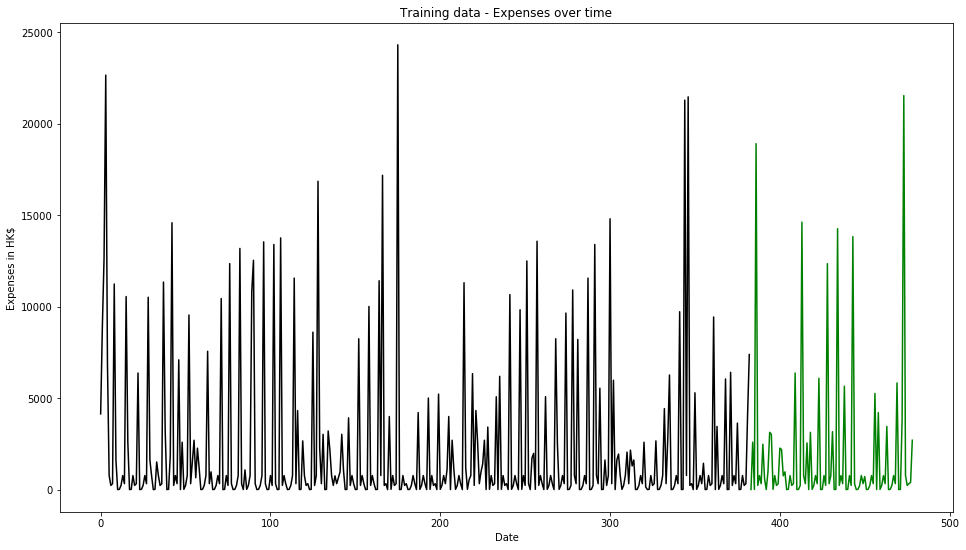

In [16]:
plt.figure(figsize=(16, 9))
plt.title('Training data - Expenses over time')
plt.plot(single_user_data['amount'][:split], color='black')
plt.plot(single_user_data['amount'][split:], color='green')
plt.xlabel('Date')
plt.ylabel('Expenses in HK$')
plt.show()

In [17]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_np.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.summary()

2023-03-29 23:35:04.203238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 27, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm_model.fit(x_train_np, y_train_np, batch_size=1, epochs=100, verbose=1)

Epoch 1/100
383/383 [==============================] - 5s 7ms/step - loss: 21325680.0000
Epoch 2/100
383/383 [==============================] - 3s 7ms/step - loss: 21280714.0000
Epoch 3/100
383/383 [==============================] - 3s 7ms/step - loss: 21240894.0000
Epoch 4/100
383/383 [==============================] - 3s 7ms/step - loss: 21202170.0000
Epoch 5/100
383/383 [==============================] - 3s 7ms/step - loss: 21163996.0000
Epoch 6/100
383/383 [==============================] - 3s 7ms/step - loss: 21126146.0000
Epoch 7/100
383/383 [==============================] - 3s 9ms/step - loss: 21088690.0000
Epoch 8/100
383/383 [==============================] - 3s 8ms/step - loss: 21051216.0000
Epoch 9/100
383/383 [==============================] - 3s 7ms/step - loss: 21014242.0000
Epoch 10/100
383/383 [==============================] - 3s 8ms/step - loss: 20977808.0000
Epoch 11/100
383/383 [==============================] - 3s 7ms/step - loss: 20941476.0000
Epoch 12/100
383/38

383/383 [==============================] - 2s 6ms/step - loss: 18783492.0000
Epoch 93/100
383/383 [==============================] - 2s 6ms/step - loss: 18764854.0000
Epoch 94/100
383/383 [==============================] - 2s 6ms/step - loss: 18746498.0000
Epoch 95/100
383/383 [==============================] - 3s 7ms/step - loss: 18728198.0000
Epoch 96/100
383/383 [==============================] - 3s 7ms/step - loss: 18710018.0000
Epoch 97/100
383/383 [==============================] - 2s 6ms/step - loss: 18691868.0000
Epoch 98/100
383/383 [==============================] - 2s 6ms/step - loss: 18673892.0000
Epoch 99/100
383/383 [==============================] - 2s 6ms/step - loss: 18656246.0000
Epoch 100/100
383/383 [==============================] - 3s 7ms/step - loss: 18638696.0000


In [19]:
y_predicted = lstm_model.predict(x_test_np)
print(y_predicted.shape)
# y_predicted = scaler.inverse_transform(y_predicted)

(96, 1)


In [ ]:
x_test_

In [20]:
y_test_transformed = scaler.inverse_transform(y_test_np)
print('Validation Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test_np, y_predicted)))

Validation Root Mean Square Error (RMSE): 4152.0906568972105


In [22]:
actual = test.reset_index()
validation = actual.filter(['amount'])
validation['Prediction'] = y_predicted
validation

,amount,Prediction
0,5.256,774.162354
1,2592.000,774.162354
2,16.560,774.162354
3,18900.000,774.162354
4,231.840,774.162354
...,...,...
91,770.400,774.162354
92,231.840,774.162354
93,326.880,774.162354
94,396.000,774.162354


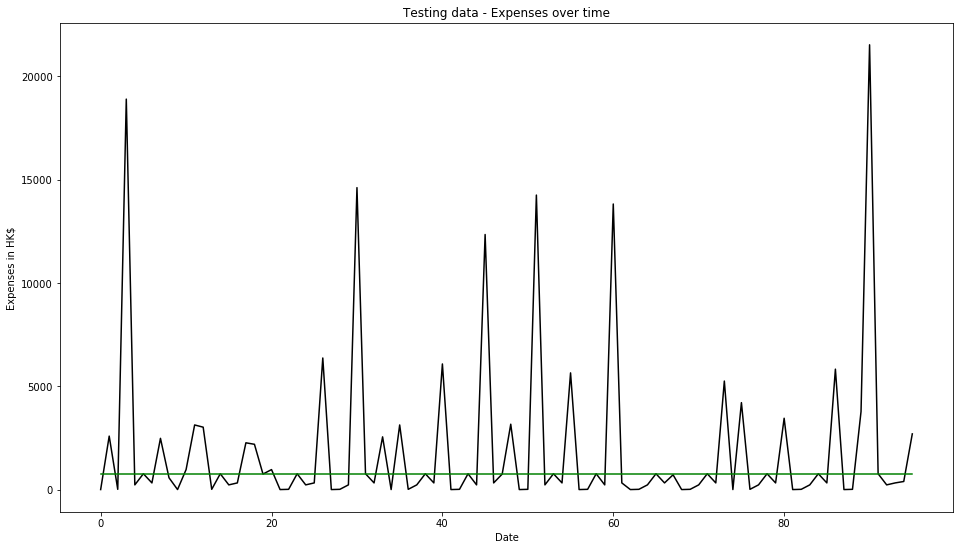

In [23]:

plt.figure(figsize=(16, 9))
plt.title('Testing data - Expenses over time')
plt.plot(actual['amount'], color='black')
plt.plot(y_predicted, color='green')
plt.xlabel('Date')
plt.ylabel('Expenses in HK$')
plt.show()

In [31]:
test

,index,trans_id,account_id,type,amount,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
383,13560,29714,96,1,5.256,5.256,7380.000,4104.000,326.880,231.840,...,5.256,6048.000,326.880,770.400,231.840,16.560,6,30,11,1997
384,13561,29587,96,1,2592.000,2592.000,5.256,7380.000,4104.000,326.880,...,16.560,5.256,6048.000,326.880,770.400,231.840,2,3,12,1997
385,13562,29455,96,1,16.560,16.560,2592.000,5.256,7380.000,4104.000,...,6408.000,16.560,5.256,6048.000,326.880,770.400,0,8,12,1997
386,13563,29798,96,1,18900.000,18900.000,16.560,2592.000,5.256,7380.000,...,231.840,6408.000,16.560,5.256,6048.000,326.880,3,11,12,1997
387,13564,29527,96,1,231.840,231.840,18900.000,16.560,2592.000,5.256,...,770.400,231.840,6408.000,16.560,5.256,6048.000,3,11,12,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,13651,29395,96,1,770.400,770.400,21528.000,3780.000,16.560,5.256,...,231.840,16.560,4212.000,5.256,5256.000,326.880,4,11,12,1998
475,13652,29539,96,1,231.840,231.840,770.400,21528.000,3780.000,16.560,...,770.400,231.840,16.560,4212.000,5.256,5256.000,4,11,12,1998
476,13653,29323,96,1,326.880,326.880,231.840,770.400,21528.000,3780.000,...,326.880,770.400,231.840,16.560,4212.000,5.256,0,14,12,1998
477,13654,29815,96,1,396.000,396.000,326.880,231.840,770.400,21528.000,...,3456.000,326.880,770.400,231.840,16.560,4212.000,5,19,12,1998


In [45]:
test.iloc[1]

index            13561.000
trans_id         29587.000
account_id          96.000
type                 1.000
amount            2592.000
last_trans_1      2592.000
last_trans_2         5.256
last_trans_3      7380.000
last_trans_4      4104.000
last_trans_5       326.880
last_trans_6       231.840
last_trans_7       770.400
last_trans_8        16.560
last_trans_9         5.256
last_trans_10     3636.000
last_trans_11      326.880
last_trans_12      770.400
last_trans_13      231.840
last_trans_14     6408.000
last_trans_15       16.560
last_trans_16        5.256
last_trans_17     6048.000
last_trans_18      326.880
last_trans_19      770.400
last_trans_20      231.840
weekday              2.000
day                  3.000
month               12.000
year              1997.000
Name: 384, dtype: float64

In [33]:
import joblib

joblib.dump(lstm_model, 'lstm_model.pkl')
lr = joblib.load('lstm_model.pkl')
lstm_columns = list(x_t.columns)
joblib.dump(lstm_columns, 'lstm_columns.pkl')

2023-03-29 22:37:20.735864: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://99bbd352-c036-4696-a19d-f93a4a035a9a/assets


INFO:tensorflow:Assets written to: ram://99bbd352-c036-4696-a19d-f93a4a035a9a/assets


['lstm_columns.pkl']